In [1]:
from collections import Counter
from dotenv import dotenv_values
import json
import matplotlib.pyplot as plt
from music_symbol import MusicSymbol
import numpy as np
import os
from pathlib import Path
from response_metrics import ResponseMetrics
import sys

# Importing from parent directory
curr_file = Path(os.path.abspath('')).resolve()
sys.path.append(str(curr_file.parent))
from scripts.backup_data import main as load_data

In [2]:
backup_prefix = "20230507-132709"
# Set to None to pull from the database live
# backup_prefix = None

if backup_prefix is None:
    config = dotenv_values("../.env")
    ENDPOINT = config["ENDPOINT"]

    print("Grabbing data from DB")
    users_data, sheets_data, measures_data = load_data(ENDPOINT, "../backups")
else:
    print("Loading from backups")
    with open(f"../backups/{backup_prefix}_users_backup.json", "r") as file:
        users_data = json.load(file)

    with open(f"../backups/{backup_prefix}_sheets_backup.json", "r") as file:
        sheets_data = json.load(file)

    with open(f"../backups/{backup_prefix}_measures_backup.json", "r") as file:
        measures_data = json.load(file)

Loading from backups


In [3]:
response_data: dict[str, ResponseMetrics] = {}
crowdsourced_response_data: dict[str, ResponseMetrics] = {}
crowdsourced_agreement_count: int = 0

for measure in measures_data:
    gold_symbols: list[MusicSymbol] = []
    for symbol in measure["goldSymbols"]:
        gold_symbols.append(MusicSymbol(**symbol))
    
    while (len(gold_symbols) < 4):
        gold_symbols.append(None)
    
    response_counter = Counter()

    for response in measure["responses"]:
        response_id = response["_id"]
        user_symbols: list[MusicSymbol] = []
        for symbol in response["symbols"]:
            user_symbols.append(MusicSymbol(**symbol))
        
        while (len(user_symbols) < 4):
            user_symbols.append(None)

        response_counter[tuple(user_symbols)] += 1
    
        response_data[response_id] = ResponseMetrics(user_symbols, gold_symbols)
    
    # no responses, skip
    if len(response_counter) == 0:
        continue

    measure_id = measure["_id"]
    crowdsourced_symbols, primary_count = response_counter.most_common(1)[0]

    if len(response_counter) >= 2:
        # get the count of the second most frequent item
        second_count = response_counter.most_common(2)[1][1]

        # tie, no crowdsourced answer
        if primary_count > second_count:
            crowdsourced_agreement_count += 1
    else:
        crowdsourced_agreement_count += 1
    
    crowdsourced_response_data[measure_id] = ResponseMetrics(list(crowdsourced_symbols), gold_symbols)

In [4]:
def calculate_statistics(datapoints: list[int], title: str) -> None:
    print(title)
    print("-" * len(title))
    print(f"{'Count:':<7} {len(datapoints):.4f}")
    print(f"{'Min:':<7} {np.min(datapoints):.4f}")
    print(f"{'Max:':<7} {np.max(datapoints):.4f}")
    print(f"{'Median:':<7} {np.median(datapoints):.4f}")
    print(f"{'Mean:':<7} {np.mean(datapoints):.4f}")
    print(f"{'Stddev:':<7} {np.std(datapoints):.4f}")
    print()

def calculate_response_statistics(response_metrics_map: dict[str, ResponseMetrics], key_group: list[str], title: str, units: str="responses", print_results: bool=True):
    symbol_num_match_count = 0
    name_match_count = 0
    pitch_match_count = 0
    exact_match_count = 0
    
    pitch_count = 0
    total_count = len(key_group)
    for key in key_group:
        if response_metrics_map[key].full_symbol_count_match():
            symbol_num_match_count += 1

        if response_metrics_map[key].full_name_match():
            name_match_count += 1
        
        pitch_match = response_metrics_map[key].full_pitch_match()
        if pitch_match is not None:
            pitch_count += 1

            if pitch_match:
                pitch_match_count += 1
        
        if response_metrics_map[key].full_exact_match():
            exact_match_count += 1
    
    symbol_num_match_accuracy = symbol_num_match_count / total_count
    name_match_accuracy = name_match_count / total_count
    pitch_match_accuracy = pitch_match_count / pitch_count
    exact_match_accuracy = exact_match_count / total_count

    if print_results:
        print(title)
        print("-" * len(title))
        print(f"{total_count} {units}, {pitch_count} {units} with pitch content")
        print(f"{'Symbol count accuracy:':<35} {symbol_num_match_count}/{total_count} {units} = {symbol_num_match_accuracy * 100:.4f}%")
        print(f"{'Symbol identification accuracy:':<35} {name_match_count}/{total_count} {units} = {name_match_accuracy * 100:.4f}%")
        print(f"{'Symbol pitch accuracy:':<35} {pitch_match_count}/{pitch_count} {units} = {pitch_match_accuracy * 100:.4f}%")
        print(f"{'Symbol exact match accuracy:':<35} {exact_match_count}/{total_count} {units} = {exact_match_accuracy * 100:.4f}%")
    
    return symbol_num_match_accuracy, name_match_accuracy, pitch_match_accuracy, exact_match_accuracy

In [5]:
responses_by_user: dict[str, list] = dict()
for measure in measures_data:
    for response in measure["responses"]:
        if "userId" not in response:
            # TODO: There were a couple responses that had no attached userId
            # might have been a hiccup of our system for caching user ids
            continue
        else:
            user_id = response["userId"]
        response_id = response["_id"]

        if user_id not in responses_by_user:
            responses_by_user[user_id] = []
        
        responses_by_user[user_id].append(response_id)

users_by_experience: dict[str, list[str]] = dict()

for user in users_data:
    experience = user["experience"]
    user_id = user["_id"]

    # omit users with no responses
    if user_id not in responses_by_user:
        continue

    if experience not in users_by_experience:
        users_by_experience[experience] = []

    users_by_experience[experience].append(user_id)

## High Level Metrics

In [6]:
experience_levels = ["Zero experience", "Some previous experience", "Actively work with sheet music"]

print(f"Total number of users: {sum([len(users_by_experience[experience_level]) for experience_level in experience_levels])}")


for experience_level in experience_levels:
    print(f"Number of users with experience level: {experience_level}: {len(users_by_experience[experience_level])}")

Total number of users: 47
Number of users with experience level: Zero experience: 32
Number of users with experience level: Some previous experience: 14
Number of users with experience level: Actively work with sheet music: 1


In [7]:
print(f"Total number of sheets: {len(sheets_data)}")
print(f"Total number of measures: {len(measures_data)}")

responses = 0
for measure in measures_data:
    responses += len(measure["responses"])

print(f"Total number of responses: {responses}")

for experience_level in experience_levels:
    response_count = sum([len(responses_by_user[user_id]) for user_id in responses_by_user.keys() if user_id in users_by_experience[experience_level]])
    print(f"Responses from users with experience '{experience_level}': {response_count}")

Total number of sheets: 3
Total number of measures: 48
Total number of responses: 434
Responses from users with experience 'Zero experience': 290
Responses from users with experience 'Some previous experience': 125
Responses from users with experience 'Actively work with sheet music': 8


In [8]:
response_counts_per_measure = [len(measure["responses"]) for measure in measures_data]
calculate_statistics(response_counts_per_measure, "Response Counts per Measure")

Response Counts per Measure
---------------------------
Count:  48.0000
Min:    8.0000
Max:    10.0000
Median: 9.0000
Mean:   9.0417
Stddev: 0.2857



In [9]:
response_counts_per_user = [len(val) for val in responses_by_user.values()]
calculate_statistics(response_counts_per_user, "Response Counts per User")

Response Counts per User
------------------------
Count:  47.0000
Min:    1.0000
Max:    21.0000
Median: 8.0000
Mean:   9.0000
Stddev: 3.7756



## Response Statistics

In [10]:
calculate_response_statistics(response_data, response_data.keys(), title="All response data metrics")
pass

All response data metrics
-------------------------
434 responses, 373 responses with pitch content
Symbol count accuracy:              408/434 responses = 94.0092%
Symbol identification accuracy:     375/434 responses = 86.4055%
Symbol pitch accuracy:              249/373 responses = 66.7560%
Symbol exact match accuracy:        294/434 responses = 67.7419%


In [11]:
calculate_response_statistics(crowdsourced_response_data, crowdsourced_response_data.keys(), title="Crowdsourced response data metrics", units="measures")
print(f"{'Crowd conclusively agreed on:':<35} {crowdsourced_agreement_count}/{len(crowdsourced_response_data)} measures = {crowdsourced_agreement_count / len(crowdsourced_response_data) * 100:.4f}%")

Crowdsourced response data metrics
----------------------------------
48 measures, 41 measures with pitch content
Symbol count accuracy:              48/48 measures = 100.0000%
Symbol identification accuracy:     47/48 measures = 97.9167%
Symbol pitch accuracy:              39/41 measures = 95.1220%
Symbol exact match accuracy:        46/48 measures = 95.8333%
Crowd conclusively agreed on:       46/48 measures = 95.8333%


In [12]:
for experience_level in experience_levels:
    response_ids = [responses_by_user[user_id] for user_id in responses_by_user.keys() if user_id in users_by_experience[experience_level]]
    response_ids = [id for sublist in response_ids for id in sublist]
    calculate_response_statistics(response_data, response_ids, title=f"Response data metrics for experience level '{experience_level}'")
    print()

Response data metrics for experience level 'Zero experience'
------------------------------------------------------------
290 responses, 253 responses with pitch content
Symbol count accuracy:              273/290 responses = 94.1379%
Symbol identification accuracy:     247/290 responses = 85.1724%
Symbol pitch accuracy:              163/253 responses = 64.4269%
Symbol exact match accuracy:        186/290 responses = 64.1379%

Response data metrics for experience level 'Some previous experience'
---------------------------------------------------------------------
125 responses, 104 responses with pitch content
Symbol count accuracy:              116/125 responses = 92.8000%
Symbol identification accuracy:     109/125 responses = 87.2000%
Symbol pitch accuracy:              70/104 responses = 67.3077%
Symbol exact match accuracy:        89/125 responses = 71.2000%

Response data metrics for experience level 'Actively work with sheet music'
----------------------------------------------

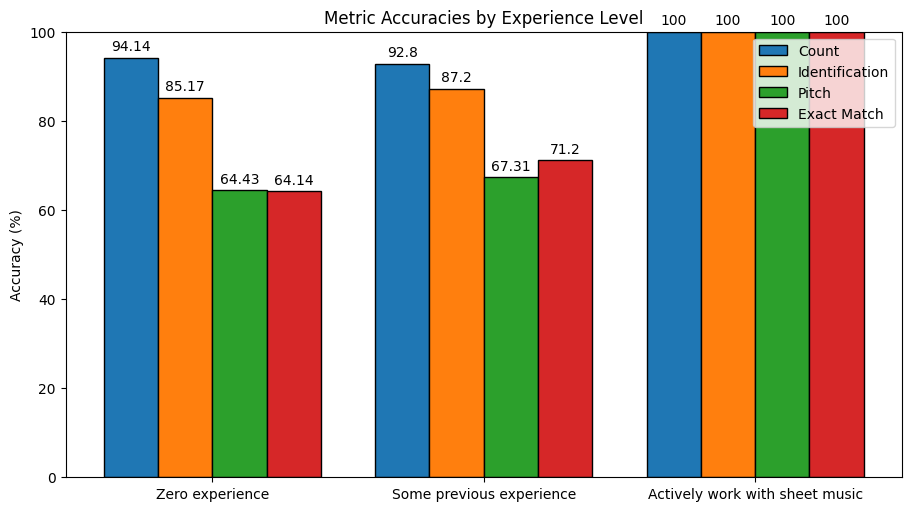

In [13]:
accuracies = {
    "Count": (94.14, 92.80, 100.00),
    "Identification": (85.17, 87.20, 100.00),
    "Pitch": (64.43, 67.31, 100.00),
    "Exact Match": (64.14, 71.20, 100.00)
}

x = np.arange(len(experience_levels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9, 5))

for attribute, measurement in accuracies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor="black")
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Metric Accuracies by Experience Level')
ax.set_xticks(x + width + 0.1, experience_levels)
ax.legend(loc='upper right')
ax.set_ylim(0, 100)

plt.show()

In [14]:
user_count_accuracy = []
user_identification_accuracy = []
user_pitch_accuracy = []
user_exact_match_accuracy = []

for responses in responses_by_user.values():
    count_acc, ident_acc, pitch_acc, exact_match_acc = calculate_response_statistics(response_data, responses, title=None, print_results=False)
    user_count_accuracy.append(count_acc)
    user_identification_accuracy.append(ident_acc)
    user_pitch_accuracy.append(pitch_acc)
    user_exact_match_accuracy.append(exact_match_acc)

calculate_statistics(user_count_accuracy, "Count Accuracy per User")
calculate_statistics(user_identification_accuracy, "Identification Accuracy per User")
calculate_statistics(user_pitch_accuracy, "Pitch Accuracy per User")
calculate_statistics(user_exact_match_accuracy, "Exact Match Accuracy per User")

Count Accuracy per User
-----------------------
Count:  47.0000
Min:    0.0000
Max:    1.0000
Median: 1.0000
Mean:   0.8973
Stddev: 0.2412

Identification Accuracy per User
--------------------------------
Count:  47.0000
Min:    0.0000
Max:    1.0000
Median: 1.0000
Mean:   0.8085
Stddev: 0.3146

Pitch Accuracy per User
-----------------------
Count:  47.0000
Min:    0.0000
Max:    1.0000
Median: 0.8000
Mean:   0.6008
Stddev: 0.4064

Exact Match Accuracy per User
-----------------------------
Count:  47.0000
Min:    0.0000
Max:    1.0000
Median: 0.7000
Mean:   0.6113
Stddev: 0.3700

